In [347]:
import networkx as nx
import reduction
import simulate
import numpy as np
import matplotlib.pyplot as plt


def get_edge_labels_dic(G):
    edge_labels = {}
    for e in G.edges:
        edge_labels[e] = G.get_edge_data(e[0],e[1])['weight']    
    return edge_labels

def permute_timescales(G):
    edge_labels = get_edge_labels_dic(G)
    vals = list(edge_labels.values())
    perm = np.random.permutation(len(vals))
    for i,e in enumerate(edge_labels):
        edge_labels[e] = vals[perm[i]]
    nx.set_edge_attributes(G,edge_labels,'weight')
    
def plot_dynamics(G,title='',timescale=5):
    X = np.zeros((len(G.edges),3)).astype(np.int32)
    node_names = []
    for n in G:
        node_names.append(n)
    for i,e  in enumerate(G.edges):
        X[i,0] = node_names.index(e[0])
        X[i,1] = node_names.index(e[1])
        X[i,2] = G.get_edge_data(e[0],e[1])['weight']
    XX = simulate.simulate(X, timescale)
    t0 = 0
    tmax = 10**timescale
    steps = XX.shape[0]
    t = np.linspace(t0, tmax, steps)
    simulate.plot_trace(XX,logy=False,logx=True,labels=node_names,time=t)
    plt.title(title)
    plt.show()


In [272]:
#filename = "models/prisme.csv"
filename = "models/flower_4.csv"
reduced_filename = "%s_reduced" % filename
timescale = 5

In [284]:
# loading sif file
#filename = "/mnt/c/Datas/Dorothea/e2f1.sif"
filename = "/mnt/c/Datas/Dorothea/MYCN.sif"
node_names = []
edges = []
with open(filename,'r') as f:
    l = f.readline()[:-1]
    while l:
        prts = l.split('\t')
        sr = prts[0]
        tg = prts[2]
        if not (sr in node_names):
            node_names.append(sr)
        if not (tg in node_names):
            node_names.append(tg)
        edges.append((sr,tg))
        l = f.readline()[:-1]
print(edges)

with open(filename[:-4]+'.csv','w') as f:
    f.write('source;target;weight\n')
    for i,e in enumerate(edges):
        f.write(str(e[0])+';'+str(e[1])+';'+str(i)+'\n')
        
filename = filename[:-4]+'.csv'
reduced_filename = "%s_reduced" % filename
timescale = 5

[('E2F3', 'E2F1'), ('E2F3', 'MYCN'), ('E2F2', 'E2F1'), ('E2F2', 'MYCN'), ('MYCN', 'TP53'), ('TP53', 'E2F1'), ('TP53', 'E2F3'), ('E2F1', 'E2F3'), ('E2F1', 'TP53'), ('E2F1', 'MYCN')]


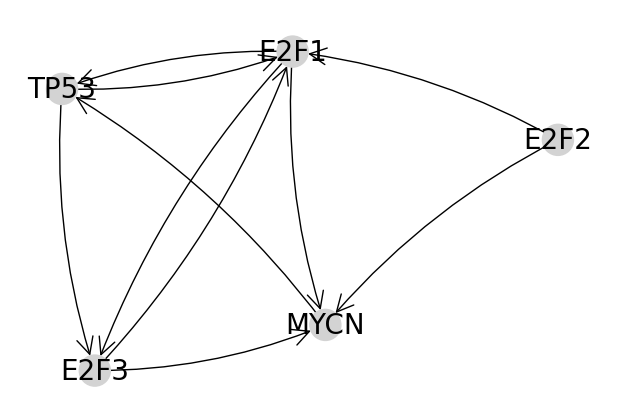

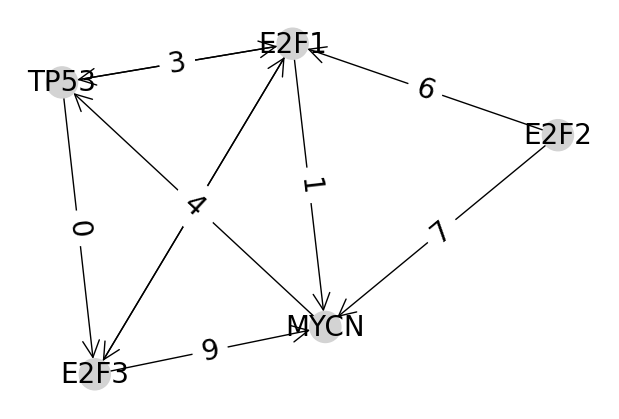

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 6)]


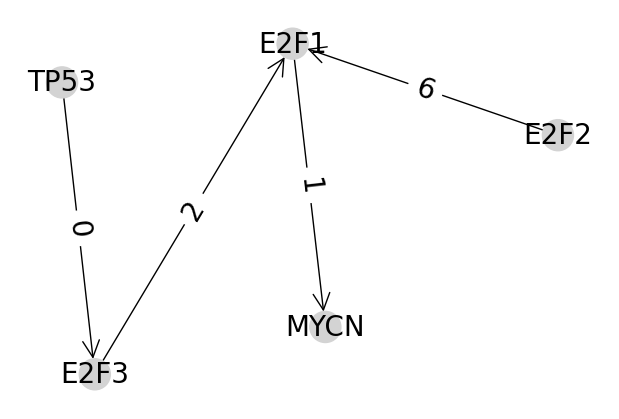

In [288]:
G = reduction.load(filename)

plt.rcParams['figure.dpi']= 100

node_names = []
for n in G:
    node_names.append(n)

color_map = []
for node in G:
    color_map.append('lightgray')
    
pos = nx.nx_pydot.graphviz_layout(G)
nx.draw(G, pos,with_labels = True,node_color=color_map,
        font_size=20,node_size=500,arrowsize=30,arrowstyle='->',
       connectionstyle="arc3,rad=0.1")
edge_labels = get_edge_labels_dic(G)
#nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='black',font_size=20)
plt.show()

permute_timescales(G)
edge_labels = get_edge_labels_dic(G)

nx.draw(G, pos,with_labels = True,node_color=color_map,font_size=20,node_size=500,arrowsize=30,arrowstyle='->')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,font_color='black',font_size=20)
plt.show()

uG = reduction.reduce_graph(G)
reduction.save_graph(uG, reduced_filename)
nx.draw(uG, pos, with_labels = True,node_color=color_map,font_size=20,node_size=500,arrowsize=30,arrowstyle='->')
edge_labels = get_edge_labels_dic(uG)
nx.draw_networkx_edge_labels(uG,pos,edge_labels=edge_labels,font_color='black',font_size=20)
plt.show()

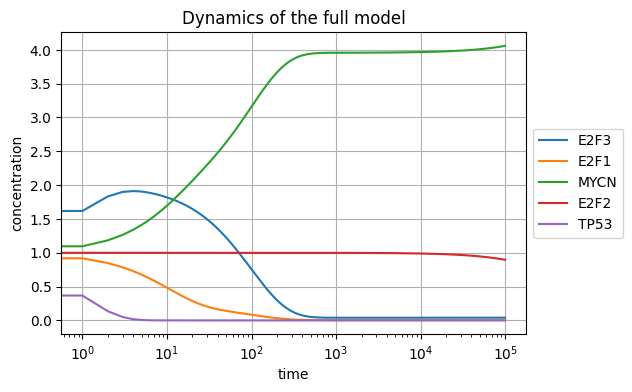

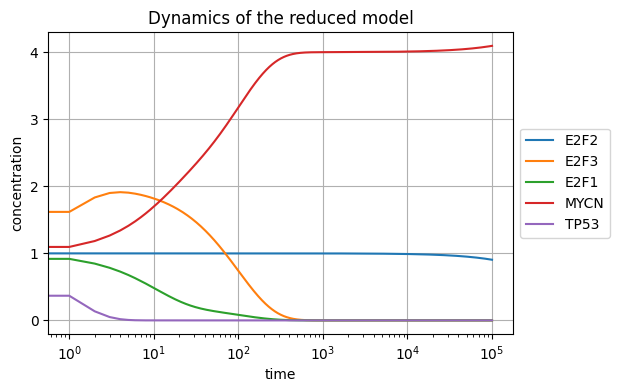

In [319]:
plot_dynamics(G,title='Dynamics of the full model')
plot_dynamics(uG,title='Dynamics of the reduced model')


In [303]:
# generate many permuted graphs
graphs = []
number_of_permutations = 10000
for i in range(number_of_permutations):
    G1 = G.copy()
    permute_timescales(G1)
    graphs.append(G1)

In [304]:
# generate a list of unique up to isomorphism graphs

def nm(n1,n2):
    if n1['id']==n2['id']:
        return True
    else:
        return False
    

unique_reduced = []
counts = []
for gr in graphs:
    ugr = reduction.reduce_graph(gr)
    node_ids = {}
    for n in ugr.nodes:
        node_ids[n] = n
    nx.set_node_attributes(ugr,node_ids,'id')    
    found = False
    for i,red_gr in enumerate(unique_reduced):
        node_ids = {}
        for n in red_gr.nodes:
            node_ids[n] = n
        nx.set_node_attributes(red_gr,node_ids,'id')
        if nx.is_isomorphic(ugr,red_gr,node_match=nm):
        #if nx.is_isomorphic(ugr,red_gr):
            found = True
            counts[i] = counts[i]+1
    if not found:
        unique_reduced.append(ugr)
        counts.append(1)
print(len(unique_reduced))
print(counts)
total_counts = 0
for c in counts:
    total_counts+=c

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'E2F1', 8), ('E2F1', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 7), ('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 7), ('E2F1', 'E2F3', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 1), ('E2F1', 'E2F3', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 3), ('TP53'

    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('MYCN', 'E2F1', 2)] [('MYCN', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('MYCN', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 3)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F3', 'E2F1', 1), ('MYCN', 'E2F1', 2)] [('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 2)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 3), ('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 9)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 3), ('E

    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 3), ('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'E2F3', 5)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 5)] [('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2'

    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 2)] [('E2F1', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3), ('E2F1', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('E2F2', 'E2F3', 6)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 6)] [('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('E2F2', 'MYCN', 7)]
ungluin

    Restore incoming edges [('E2F3', 'E2F1', 5), ('E2F2', 'E2F1', 0)] [('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3), ('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 7), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 8)] [('E2F2', 'MYCN', 8)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 8)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [] [('MYCN', 'TP53', 7)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 12)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 7), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 1), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 2)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 1), ('E2F1'

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 5)] [('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 1), ('E2F1'

    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 0), ('E2F1', 'TP53', 7)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 2), ('E2F2', 'E2F1', 1)] [('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 5)]
    Restore incoming edges [('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 1)] [('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 5), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 5), ('E2F2', 'MYCN', 5

    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 4), ('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 2)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 3)] [('TP53', 'E2F1', 5), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 4), ('E2F2', 'E2F1', 3)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'MYCN', 6)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F2', 'MYCN', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 3)] [('MYCN', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 0), ('MYCN', 'TP53', 3

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F1', 'TP53', 6), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2), ('MYCN', 'E2F1', 6), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5), ('E2F1', 'E2F3', 2)]
    Restore incoming edge

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 4), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 4), ('TP53', 'E2F1', 2), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3), ('E2F1', 'MYCN', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 0)]
ungluin

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 2), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 4), ('TP53', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F1', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 3), ('MYCN', 'TP53', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 3), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 0)]
ungluin

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 2), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 4)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 3)] [('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'MYCN', 6)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'TP53', 6)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F2', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F3', 5), ('E2F3', 'TP5

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 4)] [('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 4)] [('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 3), ('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F3': OutEdgeD

    Restore incoming edges [('E2F2', 'E2F1', 8)] [('E2F2', 'E2F1', 8)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 8)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 5), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 8)] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 8)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 8)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'M

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 4)] [('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'E2F3', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 8)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 8), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MY

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 3), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 6), ('TP53', 'E2F3', 0)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 4)] [('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 0), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 4)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 7)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 7), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2

    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 0)] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 7), ('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F3', 5)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5), ('E2F2', 'E2F3', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E

    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'MYCN', 9)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 5)] [('MYCN', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 5)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 5)]
ungluing: {'E2F3':

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 8)] [('E2F2', 'MYCN', 8)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 8)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 8)] [('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 8)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 8)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 7), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F1', 6), ('E2F1', 'TP5

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 1)] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 0), ('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP5

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 6)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 6), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F1', 5), ('E2F1', 'TP53', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 6), ('E2F2', 'TP53', 4)] [('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('TP53', 'E2F1', 5), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('E2F1', 'E2F

    Restore incoming edges [('E2F1', 'TP53', 3)] [('E2F1', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F1', 'TP53', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'TP53', 5), ('TP53', 'E2F3', 5)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 5), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F3', 'E2F1', 5), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 5), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 5), ('E2F3', 'E2F1', 6)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 6)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 6)] [('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2), ('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP

    Restore incoming edges [('MYCN', 'E2F1', 4), ('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 0)] [('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 4), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 1), ('MYCN', 'TP53', 4), ('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 6), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('TP53', 'MYCN', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 0)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 7

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 5), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 3)] [('E2F1', 'TP53', 0), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53

    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2), ('E2F1', 'TP53', 0)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3), ('E2F1', 'MYCN', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3), ('E2F2', 'MYCN', 6)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 2)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 3)] [('TP53', 'E2F3', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('M

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 9)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F1', 'TP53', 0)] [('E2F1', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 4), ('E2F1', 'TP53', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 6), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 3), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 

ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 4)] [('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3), ('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 1)] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 12)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 5)] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 2), ('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 9)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 5), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)] [('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 8)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 5), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 6), ('MYCN', 'E2F

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 0), ('E2F1', 'MYCN', 5)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 8)] [('E2F2', 'MYCN', 8)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 0), ('E2F2', 'MYCN', 8)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 3), ('TP53', 'E2F3', 2)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('MYCN', 'E2F1', 0)] [('MYCN', 'TP53', 0)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 2), ('MYCN', 'TP53', 0)]
ungluin

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 4), ('E2F3', 'E2F1', 8)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'E2F3', 4)] [('E2F1', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F1', 'E2F3', 4)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 5), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'E2F1', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 5), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 2), ('TP53', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'TP53', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 3), ('E2F1', 'TP53', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'E2F1', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3',

    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 8), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 3), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 3)]
    Restore incoming edges [] [('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 3), ('TP53', 'MYCN', 8)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 1), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 1), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 8), ('E2F1', 'TP53', 5), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 5), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('MYCN', 'E2F3', 1), ('E2F2', 'E2F3', 2)] [('MYCN', 'TP53', 1), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 5), ('TP53', 'E2F3',

    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 5), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 5), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'E2F3', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 7)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 7), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1), ('MYCN', 'E2F3', 7), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 6), ('TP53', 

    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 6)]
    Restore incoming edges [('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 0)] [('E2F1', 'E2F3', 4), ('E2F2

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'MYCN', 8)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 4), ('E2F2', 'MYCN', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 4)] [('MYCN', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 2), ('MYCN', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 1)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F3', 'TP53', 2), ('MYCN', 'TP53', 4)] [('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 7)]
    Resto

    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 5), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 5)]
    Restore incoming edges [('MYCN', 'TP53', 3)] [('MYCN', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 5), ('MYCN', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F1', 'TP53', 3)] [('E2F1', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('E2F1', 'TP53', 3

ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('TP53', 'E2F3', 5), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 5), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 4)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 3)] [('TP53', 'E2F3', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'MYC

    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('TP53', 'E2F3', 3), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 1)])}
    TP53 

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 7), ('E2F3', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 3), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 6), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 5), ('E2F2', 'MYCN', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 2), ('TP53', 'E2F

    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 7), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 4)] [('E2F3', 'E2F1', 6), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 3), ('E2F3', 'E2F1', 6), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 5), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 7), ('E2F1', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 6)]
    Restore inc

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'E2F1', 3), ('E2F1', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F1', 3), ('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F1', 3), ('E2F1', 'MYCN', 5), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 4)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('TP53', 'E2F1', 3)] [('TP53', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 5), ('TP53', 'E2F1', 3)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'E2F1', 6), ('E2F1', 'MYCN', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 5), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F

    Restore incoming edges [('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 3)] [('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 12)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 9), ('TP53', 'E2F1', 5)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 5)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)] [('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 5), ('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 3), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 3)]
    Re

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 6), ('E2F3', 'MYCN', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53'

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 5), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 8)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 8), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 9)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 8)]
ungluing: {'MYCN': OutEdge

    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 4)] [('MYCN', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('MYCN', 'TP53', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 6), ('TP53', 'E2F1', 4)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 4)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 1)] [('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 4), ('E2F3', 'E2F1', 0

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 2), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('TP53', 'E2F3', 3), ('E2F3', 'TP53', 7)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 4)] [('MYCN', 'TP53', 2), ('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 3), ('MYCN', 'TP53', 2), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 3), ('E2F2', 'E2F3', 4)] [('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'E2F1', 2), ('E2F1', 'MYCN', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 2), ('E2F2', 'MYCN', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 4)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('TP53', 'E2F1', 2)] [('TP53', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3',

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 2)] [('E2F1', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 1), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 3)] [('E2F1', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'TP53', 4), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('E2F2', 'TP53', 6)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 3), ('E2F2', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP5

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 7), ('E2F1', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 4)] [('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 4)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 8)] [('E2F2', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 0), ('E2F2', 'TP53', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP5

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 6)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 3), ('E2F1', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 3)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 0)]
ungluin

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 0)] [('TP53', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F3', 'MYCN', 5), ('TP53'

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 6), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 6), ('E2F2', 'MYCN', 0)] [('E2F1', 'MYCN', 6), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3), ('E2F1', 'MYCN', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 7)] [('E2F2', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F2', 'TP53', 7)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP5

    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 0), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 1)] [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 0), ('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 9), ('E2F1', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 6), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 5)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 3)]
    Restore incoming edges

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 12)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 4), ('E2F1', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 0), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 0), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('TP53', 'E2F3', 6), ('E2F3', 'TP53', 7)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 6)]
    Rest

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 5), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 4)] [('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 9)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP5

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 7), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 4)] [('E2F3', 'E2F1', 1), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 1), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 7)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 5), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 5), ('TP53', 'E2F1', 2)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 3), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 6)] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 6)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 3), ('TP53'

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 4), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 4), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('MYCN', 'E2F3', 4), ('E2F2', 'E2F3', 1)] [('MYCN', 'TP53', 4), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 3), ('TP53', 'E2F3', 0), ('MYCN', 'TP53', 4), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 7), ('E2F2', 'MYCN', 0)]
ungluin

ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'TP53', 7), ('TP53', 'E2F3', 6)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 6)]
    Restore incoming edges [('MYCN', 'E2F3', 1), ('E2F2', 'E2F3', 3)] [('MYCN', 'TP53', 1), ('E2F2', 'TP53', 3)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 6), ('MYCN', 'TP53', 1), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 1), ('E2F2', 'TP53', 3)] [('E2F3', 'E2F1', 7), ('MYCN', 'TP53', 1), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 6), ('MYCN', 'TP53', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeD

ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F3', 0)] [('MYCN', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 3), ('MYCN', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 1)]
    Restore incoming edges [('MYCN', 'E2F1', 0)] [('E2F3', 'E2F1', 4), ('MYCN', 'TP53', 0)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 1), ('E2F1', 'E2F3', 3), ('MYCN', 'TP53', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 0), ('TP53', 

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'E2F3', 6), ('E2F3', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 6), ('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 6), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 6)] [('TP53', 'E2F3', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 0)])}
    MYCN (l

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 0)] [('E2F1', 'TP53', 1), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 5), ('E2F1', 'TP53', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F1', 1), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'MYCN', 2), ('MYCN', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['E2F1'] [('E2F3', 'MYCN', 2), ('MYCN', 'E2F1', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 5), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 1)] [('MYCN', 'TP53', 1)]
    Rea

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 8)] [('E2F2', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F2', 'TP53', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 2), ('E2F2', 'TP53', 8)] [('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 8)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 8)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 6)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 4)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 1)] [('TP53', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 4), ('TP53', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)])}
    MYCN (l

    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 4), ('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 5), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 1), ('TP53', 'MYCN', 5), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F1', 1), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'MYCN', 0), ('MYCN', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 3)] [('E2F2', 'MYCN', 3)]
    Rea

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F2', 'MYCN', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 1), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F3', 0)]
    Ready to ungl

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F1', 8), ('E2F1', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('E2F1', 'E2F3', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F1', 'E2F3', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 1)]
    Restore incoming edges [] [('MYCN', 'TP53', 8)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 1), ('E2F1', 'E2F3', 6)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 3), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'TP53', 2), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 2), ('TP53'

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1), ('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F1', 'TP53', 0)] [('E2F1', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 4), ('E2F1', 'TP53', 0)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 3), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 3), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3':

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 7), ('TP53', 'E2F1', 4)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 4)]
    Restore incoming edges [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 1)] [('E2F3', 'E2F1', 6), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 4), ('E2F3', 'E2F1', 6), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 4), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 4), ('E2F1'

    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 1), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3), ('E2F1', 'E2F3', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 7), ('E2F1', 'E2F3', 4), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 4), ('TP53', 'E2F1', 1)]
    Re

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 4), ('E2F1', 'MYCN', 7)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 4), ('E2F2', 'MYCN', 6)]
ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 1), ('E2F1', 'TP53', 3)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 1)]
    Restore incoming edges [('MYCN', 'E2F1', 4)] [('MYCN', 'TP53', 4)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 1), ('MYCN', 'TP53', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 2)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 1)] [('TP53', 'E2F3', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
 

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 9)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F1', 'TP53', 1)] [('E2F1', 'E2F3', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('E2F1', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 3), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 3), ('E2F2', 'MYCN', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 14)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 8)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 8), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 8)] [('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 8)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 8)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'MYCN', 8)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5)]
    Rest

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'MYCN', 13)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('MYCN', 'TP53', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('MYCN', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 3), ('MYCN', 'TP53', 2)] [('E2F3', 'E2F1', 3), ('MYCN', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 3), ('MYCN', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'MYCN', 8)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 1)]
    Rest

    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 4)] [('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1), ('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F1', 3), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'MYCN', 0), ('MYCN', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['E2F1'] [('E2F3', 'MYCN', 0), ('MYCN', 'E2F1', 3), ('E2F2', 'MYCN', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 1)]
    Res

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 6), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)] [('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 3), ('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN

    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 8)] [('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 8)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 2), ('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 7)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 7), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 7)] [('MYCN', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('MYCN', 'TP53', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F3', 14)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)]

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 6), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 6)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 6), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('TP53', 'E2F3', 3), ('E2F3', 'TP53', 6)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F3', 6)] [('MYCN', 'TP53', 6)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 3), ('MYCN', 'TP53', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 3)] [('TP53', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 6), ('E2F1', 'MYCN', 2), ('TP53', 

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 6), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F3', 5), ('E2F3', 'TP53', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F3', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 4), ('TP53', 'MYCN', 6), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('TP53', 'E2F1', 5), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'TP53', 4), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 1)] [('E2F1', 'E2F3', 2), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('TP53', 'E2F3', 0), ('E2F1', 'E2F3', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 1)] [('E2F1', 'MYCN', 0), ('E2F2'

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 2)] [('E2F3', 'MYCN', 6), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 6), ('E2F2', 'E2F1', 2)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 8)] [('E2F2', 'MYCN', 8)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F2', 'MYCN', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 4), ('E2F2', 'MYCN', 7)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 2)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 4)] [('MYCN', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 1), ('MYCN', 'TP53', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 7), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 3)]
ungluin

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'MYCN', 7), ('MYCN', 'TP53', 6)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 6)]
    Restore incoming edges [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 5)] [('E2F3', 'TP53', 1), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 6), ('E2F3', 'TP53', 1), ('E2F2', 'MYCN', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 6), ('E2F3', 'TP53', 1)] [('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 6)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 6), ('E2F3', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 3), ('E2F3', 'E2F

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 2)] [('TP53', 'E2F3', 1), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('TP53', 'E2F3', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 8)] [('E2F2', 'MYCN', 8)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 8)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP5

    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 7), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 6), ('MYCN', 'E2F1', 2)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F3', 'E2F1', 8), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 2), ('E2F1', 'E2F3', 7), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 2)] [('E2F3', 'E2F1', 8), ('MYCN', 'TP53', 2)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F1', 'E2F3', 7), ('MYCN', 'TP53', 2)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 9), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 4)] [('E2F3', 'E2F1', 7), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 3), ('E2F3', 'E2F1', 7), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 0), ('E2F1', 'MY

ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 5), ('TP53', 'E2F1', 4)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [] [('E2F1', 'MYCN', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'E2F3', 6), ('E2F3', 'E2F1', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 6), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53'

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'TP53', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3), ('E2F1', 'TP53', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F3', 12)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1'

    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 4), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 4), ('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 4), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('MYCN', 'TP53', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 5), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)] [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'MYCN', 8)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 8)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 8), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 9)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0), ('TP53', 'MYCN', 8)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 4), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53'

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 5), ('E2F3', 'E2F1', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 6), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 5)] [('E2F3', 'E2F1', 1), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 2), ('E2F3', 'E2F1', 1), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 9), ('E2F3', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['MYCN'

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 6), ('E2F3', 'MYCN', 12)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 6)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 6), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'TP53', 8), ('TP53', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 4)]
    Restore incoming edges [('MYCN', 'E2F3', 6), ('E2F2', 'E2F3', 2)] [('MYCN', 'TP53', 6), ('E2F2', 'TP53', 2)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 4), ('MYCN', 'TP53', 6), ('E2F2', 'TP53', 2)]
unglui

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 3), ('TP53', 'E2F3', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 3), ('TP53', 'E2F3', 6), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 5)] [('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53

    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 6), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 7), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 6), ('E2F2', 'E2F3', 2)] [('TP53', 'E2F3', 6), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('TP53', 'E2F3', 6), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 4), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1'

    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 3), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 3)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 1)] [('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 3), ('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'MYCN', 9)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 4), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F3', 7), ('E2F3', 'TP53', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 4)]
    Restore incoming edges [('MYCN', 'TP53', 4), ('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 4), ('E2F2', 'E2F3', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 4), ('MYCN', 'TP53', 4), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('TP53', 'E2F1', 7), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F3', 'TP53', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 1), ('E2F3', 'E2F1', 7)])}
    E2F3 (l

ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F3'] [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F1', 0), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'MYCN', 1), ('MYCN', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F1'] [('E2F3', 'MYCN', 1), ('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 5), ('TP53', 'E2F1', 2)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 2)]
    Restore incoming edges [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 7)] [('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F1'] [('TP53'

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('TP53', 'MYCN', 6), ('MYCN', 'TP53', 8)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 6)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 6)] [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 6)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 6), ('E2F3', 'TP53', 0), ('E2F2', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 6)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('TP53', 'MYCN', 6), ('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDa

    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'TP53', 6)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 6)] [('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 6)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 7)] [('E2F2', 'E2F3', 7)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F3', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'MYCN', 10)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 2)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Rest

    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'TP53', 7), ('TP53', 'E2F3', 5)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 5)]
    Restore incoming edges [('MYCN', 'E2F3', 1)] [('MYCN', 'TP53', 1)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 5), ('MYCN', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 1)] [('E2F3', 'E2F1', 7), ('MYCN', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('TP53', 'E2F3', 5), ('MYCN', 'TP53', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 0), ('T

    Ready to unglue: ['E2F1'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 5), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 1)] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 0), ('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'

    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 8), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 6), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53',

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 6)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('TP53', 'E2F3', 1)] [('TP53', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('TP53', 'E2F3', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 8)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('MYCN', 

    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 1), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 4)] [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 1)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Res

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 9)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'E2F1', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F1', 'E2F3', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 5), ('MYCN', 'TP53', 1), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 

    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 1)] [('E2F1', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 4), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 5), ('E2F3', 'E2F1', 7)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Rea

    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('TP53', 'E2F1', 5)] [('TP53', 'E2F3', 5)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 4)] [('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 6)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 6)] [('MYCN', 'TP53', 6)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 2), ('MYCN', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 2), ('MYCN', 'TP53', 6)] [('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 6)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Rest

    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 3)] [('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 4), ('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 3), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 3), ('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 3), ('E2F1', 'E2F3', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 0)])}
    MYCN

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'E2F3', 5), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 5), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 7), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 5), ('E2F2', 'E2F3', 0)] [('TP53', 'E2F1', 5), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 5), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('MYCN'

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 2), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F3', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3), ('MYCN', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 8), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 6), ('TP53', 'E2F1', 5)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 5), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F1', 'E2F3', 6), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53'

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 6), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 3)]
    Restore incoming edges [('MYCN', 'E2F1', 6)] [('MYCN', 'E2F1', 6)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 3), ('MYCN', 'E2F1', 6)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 5), ('TP53', 'E2F

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 0)] [('E2F1', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F1', 'TP53', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 12)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2), ('E2F1', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2

    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2), ('E2F1', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 9), ('E2F1', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 7)]
    Restore incoming edges [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
    Ready to unglue

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'E2F1', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 2)] [('E2F1', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 5)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)] [('E2F3', 'E2F1', 1), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 4), ('E2F3', 'E2F1', 1), ('E2F2', 'MYCN', 0

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 4)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 4), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 1), ('TP53', 'MYCN', 4), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 5), ('TP53', 'E2F

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 2)] [('TP53', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('TP53', 'E2F3', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3',

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 7)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'E2F3', 0)] [('E2F1', 'TP53', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1), ('E2F1', 'TP53', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 8)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('MYCN', 

ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 3

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 6), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 6), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP5

    Restore incoming edges [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 1)] [('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 2), ('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3), ('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F

    Restore incoming edges [('TP53', 'E2F1', 4), ('E2F2', 'E2F1', 2)] [('TP53', 'E2F3', 4), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 4), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 8)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'E2F3', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2), ('E2F1', 'E2F3', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 3)]
    Restore incoming edges [

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'MYCN', 8)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F3', 7), ('E2F3', 'TP53', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 5)]
    Restore incoming edges [('MYCN', 'TP53', 5), ('E2F2', 'TP53', 1)] [('MYCN', 'TP53', 5), ('E2F2', 'E2F3', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 5), ('MYCN', 'TP53', 5), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('TP53', 'E2F3', 7), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'TP53', 5), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2), ('E2F1', 'E2F

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 1), ('E2F3', 'E2F1', 8)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 1)] [('E2F1', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'MYCN', 8)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 6)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 6), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 2), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 3)] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP

    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 3)] [('E2F1', 'TP53', 0), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F1', 'TP53', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3), ('E2F1', 'MYCN', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3), ('E2F2', 'MYCN', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 4)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Res

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 8)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 7)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 7), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F3', 4), ('E2F3', 'TP53', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 4)]
    Restore incoming edges [('MYCN', 'TP53', 7)] [('MYCN', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 4), ('MYCN', 'TP53', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [] [('TP53', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'TP53', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue

    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 7)] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 7)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 7)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 7), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYC

    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 2)] [('E2F1', 'TP53', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3), ('E2F1', 'TP53', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 7)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('E2F2', 'E2F3', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 6)] [('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 6)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0), ('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F

    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 9)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 5), ('MYCN', 'TP53', 3), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 4)] [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 3), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 9), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 

ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 5), ('MYCN', 'E2F1', 4)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 4)]
    Restore incoming edges [('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 7)] [('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 4), ('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 1)]
    Restore incoming edges [('MYCN', 'E2F1', 4), ('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 7)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 4), ('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 1), ('MYCN', 'TP53', 4), ('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 8)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 2)]
ungluin

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F1', 'TP53', 2)] [('E2F1', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F1', 'TP53', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'E2F3', 5)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 5), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 4), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F2', 'MYCN', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('TP53', 'E2F3', 1)] [('TP53', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('TP53', 'E2F3', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 9)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 8), ('MYCN', 'E2F1', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 6)]
    Resto

    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 7), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 1), ('TP53', 'MYCN', 7), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3'

    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('TP53', 'E2F3', 5), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 5), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 12)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'TP53', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2), ('E2F1', 'TP53', 1)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 4), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 4), ('E2F2', 'MYCN', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Resto

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 3), ('E2F3', 'E2F1', 7)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'E2F3', 3)] [('E2F1', 'MYCN', 3)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F1', 3), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'MYCN', 1), ('MYCN', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'MYCN', 1), ('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 6), ('TP53', 'E2F

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 8)] [('E2F2', 'MYCN', 8)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 8)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 8)] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 8)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 2), ('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 8)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 5), ('MYCN', 'E2F1', 6)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 5), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP5

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 2), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 4)] [('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3), ('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 7), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'TP5

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 7), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 4), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 4)]
    Restore incoming edges [] [('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 4), ('TP53', 'MYCN', 7)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 4)] [('E2F3', 'E2F1', 4), ('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('TP53', 'MYCN', 7), ('E2F3', 'E2F1', 4)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 0)]
    Res

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 12)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 4)] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'T

    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 3)] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 3), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 9)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F3', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 2), (

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 7)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 7)] [('E2F3', 'MYCN', 4), ('E2F2', 'TP53', 7)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 3), ('E2F3', 'MYCN', 4), ('E2F2', 'TP53', 7)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 7)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 7)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'MYCN', 3), ('E2F2', 'E2F1', 7)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'MYCN', 6)])}
    MYCN (

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 7), ('E2F1', 'E2F3', 4), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 4), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 4), ('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'MYCN', 10)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 9)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 9), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('MYCN', 'TP53', 9), ('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 9), ('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('MYCN', 'TP53', 9), ('E2F2', 'TP53', 0)]
unglui

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 3)] [('E2F1', 'E2F3', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 2), ('E2F1', 'E2F3', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 4), ('E2F2', 'E2F1', 3)]
ungluin

    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('MYCN', 'E2F3', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0), ('MYCN', 'TP53', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 3), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 3), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Re

    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 7)]
    Restore incoming edges [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 3)] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 7), ('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 5)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 2), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Res

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 7), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3',

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 7), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)] [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 4), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 7)] [('E2F2', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 4), ('E2F2', 'TP53', 7)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'MY

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 5), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 5), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 7), ('TP53', 'E2F3', 2)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('MYCN', 'E2F1', 5)] [('MYCN', 'TP53', 5)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 2), ('MYCN', 'TP53', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('E2F1', 'MYCN', 5), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1',

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'MYCN', 13)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 5), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 5)]
    Restore incoming edges [('MYCN', 'TP53', 3)] [('MYCN', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 5), ('MYCN', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 5), ('MYCN', 'TP53', 3)] [('E2F3', 'E2F1', 5), ('MYCN', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 5), ('MYCN', 'TP53', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4)]
    Rest

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 3)] [('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 5), ('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 4), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP5

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 6)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 3)] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 6), ('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [] [('MYCN', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('TP53', 'MYCN', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [

    Restore incoming edges [('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 2)] [('E2F3', 'E2F1', 5), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1), ('E2F3', 'E2F1', 5), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 4)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 0), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 6)])}
    E2F3 (lim:E2F3)   [('E2F1'

    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 3)] [('E2F1', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'TP53', 7), ('TP53', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 4)]
    Res

ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'TP53', 4), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('E2F2', 'TP53', 6)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 3), ('E2F2', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 3), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'E2F3', 7), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 7)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 7), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDa

    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1), ('E2F1', 'E2F3', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F1', 'TP53', 1), ('E2F2', 'TP53', 5)] [('E2F1', 'MYCN', 1),

ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'E2F1', 1)] [('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 8)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 6), ('E2F3', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 6), ('E2F3', 'E2F1', 8)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 6)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 6), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'E2F3', 6)] [('E2F1', 'MYCN', 6)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'E2F3', 11)])}
    MYCN (

    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2), ('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN',

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 1)] [('E2F1', 'TP53', 3), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2), ('E2F1', 'TP53', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 6)]
    Restore incoming edges [('E2F1', 'MYCN', 3)] [('E2F1', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 6), ('E2F1', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 7), ('E2F3', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1',

    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 5), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 4)] [('E2F3', 'E2F1', 2), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 13)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 0)] [('E2F1', 'E2F3', 3), ('E2F2

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 13)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 9), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 2)] [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'T

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 5)] [('E2F1', 'TP53', 3), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2), ('E2F1', 'TP53', 3), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 2)] [('E2F1', 'TP53', 2)]
    Ready to unglue: ['MYCN'

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F3', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 5), ('E2F2', 'E2F3', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 3)] [('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 5), ('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F3', 12)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F3', 5)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5), ('E2F2', 'E2F3', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 5)] [('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F3', 'MYCN', 5), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 6), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 6)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 6), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP5

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 5), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 5), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 5), ('TP53', 'E2F1', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('TP53', 'E2F3', 1)] [('TP53', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F3', 'MYCN', 7), ('TP53'

    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 8), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 8), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('TP53', 'E2F3', 0)] [('TP53', 'E2F1', 0)]

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 4)] [('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 6), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP5

    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 2), ('E2F3', 'MYCN', 12)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'TP53', 8), ('TP53', 'E2F3', 5)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 5)]
    Restore incoming edges [('MYCN', 'E2F3', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 5), ('MYCN', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 2)] [('E2F3', 'E2F1', 8), ('MYCN', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 5), ('MYCN', 'TP53', 2)]
ungluing: {'MYCN': OutEdgeDataView([('

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 2)] [('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'MYCN', 8)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F

    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 4), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 9)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F1', 'E2F3', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 12)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'E2F1', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 2)] [('E2F1', 'TP53', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F1'

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 6), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 6), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 7), ('E2F1', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 5), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
unglui

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 4), ('E2F3', 'E2F1', 5)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'E2F3', 4)] [('E2F1', 'TP53', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F1', 'TP53', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'E2F3', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 7)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 7), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 4), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F3', 'TP53', 5), ('MYCN', 'TP53', 0), ('E2F2', 'TP53', 1)] [('E2F3', 'E2F1', 5), ('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F3', 'E2F1', 5), ('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to ungl

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)] [('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3), ('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 4), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 4), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F3', 'TP53', 4), ('E2F2', 'TP53', 5)] [('E2F3', 'E2F1', 4), ('E2F2'

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 4), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 8)] [('E2F2', 'E2F3', 8)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 4), ('E2F2', 'E2F3', 8)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F3', 4), ('E2F2', 'E2F3', 8)] [('MYCN', 'TP53', 4), ('E2F2', 'E2F1', 8)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3), ('MYCN', 'TP53', 4), ('E2F2', 'E2F1', 8)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 6)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP5

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 1)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 0), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 2), ('E2F1', 'MYCN', 7)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 2), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'TP5

    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'E2F3', 0), ('E2F2', 'E2F3', 4)] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 5), ('MYCN', 'E2F1', 5)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 5), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [

    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 2), ('E2F1', 'E2F3', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'MYCN', 9)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 2), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 1)] [('MYCN', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 2), ('MYCN', 'TP53', 1)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3), ('E2F1', 'MYCN', 5)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]

    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 3), ('TP53', 'E2F3', 6), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 5)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 6), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F1', 'E2F3', 0)] [('E2F1'

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 8), ('E2F3', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('TP53', 'E2F3', 2), ('E2F3', 'TP53', 4)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 6), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDa

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 0)] [('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('TP53', 'E2F3', 1), ('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E

    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 7), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 7)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 3)] [('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 7), ('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F3', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 5), ('E2F2', 'E2F3', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 3)] [('TP53'

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 0), ('E2F1', 'MYCN', 7)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 8)] [('E2F2', 'E2F1', 8)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 8)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'TP53', 4), ('TP53', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 8)] [('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 8)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('TP53', 'E2F3', 1), ('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 8)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1'

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 3), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 1)] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN'

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'MYCN', 9)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F1', 6), ('E2F1', 'TP53', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 5)] [('MYCN', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('MYCN', 'TP53', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [] [('TP53', 'E2F3', 6)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 2)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 2), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue:

    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'TP53', 6)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 1), ('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 6)] [('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 1), ('E2F1', 'MYCN', 3), ('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 7)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 7), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 2), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 2)]
    Restore incoming edges 

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F3', 13)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)] [('E2F3', 'MYCN', 2), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 5), ('E2F2', 'E2F1', 7)]
unglui

    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 4), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 6), ('TP53', 'E2F3', 0)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 4)] [('MYCN', 'TP53', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 0), ('MYCN', 'TP53', 4)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'E2F1', 1), ('E2F1', 'MYCN', 7)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 4), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 4), ('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 2)] [('TP53', 'E2F3', 1), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'MYCN', 8)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 1), ('MYCN', 'TP53', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 5)])}
    E2F3 (lim:E2F3)   [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 5), ('E2F2', 'E2F1', 1)]
ungluin

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 6), ('E2F2', 'MYCN', 0)] [('E2F1', 'E2F3', 6), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 1), ('E2F1', 'E2F3', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 3), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 3)]
    Restore incoming edges [('MYCN', 'TP53', 5), ('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 5), ('E2F2'

    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'TP53', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1), ('E2F1', 'TP53', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 9), ('E2F3', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('TP53', 'E2F3', 1), ('E2F3', 'TP53', 6)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 1)]
    Restore incoming edges [] [('MYCN', 'TP53', 9)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 7)]
ungluing

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 5), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'E2F3', 3)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 5), ('E2F2', 'E2F3', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('MYCN', 'E2F3', 5), ('E2F2', 'E2F3', 3)] [('MYCN', 'TP53', 5), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0), ('MYCN', 'TP53', 5), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('E2F1'

    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 4), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F3', 'TP53', 4), ('E2F2', 'TP53', 0)] [('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 3), ('E2F3', 'E2F1', 7)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 7), ('E2F1', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 5), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 4), ('TP53', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [] [('MYCN', 'TP53', 7)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 3), ('E2F1', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53'

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 0), ('E2F1', 'MYCN', 7)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 4), ('TP53', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 2)] [('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 3), ('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 13)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP

    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 4), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 1)] [('E2F3', 'E2F1', 6), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 6), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 0), ('E2F1'

    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'MYCN', 8)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 5)] [('E2F3', 'MYCN', 0), ('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F3', 'MYCN', 0), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 2), ('E2F2', 'TP53', 5)] [('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('MYCN', 'TP53', 2

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 9)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 8)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 8), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 8)] [('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 8)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 5), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 5)]
    Resto

    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 2), ('TP53', 'E2F3', 1), ('MYCN', 'TP53', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 9)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 8), ('MYCN', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 2)] [('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 1), ('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 1), ('E2F3', 'E2F1', 3)] [('E2F3', 'E2F1', 3), ('MYCN', 'TP53', 1)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('MYCN', 'TP53', 1

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 6), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 2), ('E2F2', 'E2F3', 1)] [('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 6), ('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'MYCN', 9)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP5

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 8), ('E2F1', 'MYCN', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 8)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 8), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 0), ('E2F1', 'TP53', 6)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 8)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 8)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 2)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('TP53', 'E2F1', 0)] [('TP53', 'E2F3', 0)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 8), ('TP53', 'E2F3', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'E2F1', 3), ('E2F1', 'MYCN', 4)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F1', 3), ('E2F1', 'MYCN', 4)]
    Restore incoming edges [

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 6), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 2)] [('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1), ('E2F3', 'E2F1', 0), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 6), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'MYCN', 2), ('MYCN'

ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 2), ('E2F1', 'TP53', 5)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 2)]
    Restore incoming edges [('MYCN', 'E2F1', 6)] [('MYCN', 'TP53', 6)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 2), ('MYCN', 'TP53', 6)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 2)] [('TP53', 'E2F3', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 14)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [(

ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 7), ('MYCN', 'E2F1', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 6), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [] [('E2F1', 'E2F3', 7)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0), ('MYCN', 'E2F1', 6)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 8), ('E2F1', 'E2F3', 1)])}
    E2F3 

    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F1', 'TP53', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 4), ('E2F1', 'E2F3', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 4)] [('E2F3', 'E2F1', 6), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 5), ('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 9)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F2', 'E2F1', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F1', 'TP53', 2)] [('E2F1', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('E2F1', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'MYCN', 1)]
    Rea

    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 3), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 3), ('E2F2', 'TP53', 1)] [('E2F1', 'E2F3', 3), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2), ('E2F1', 'E2F3', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 8)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 1), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 2)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 2)]
    Restore incoming edges [

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 6), ('E2F1', 'MYCN', 7)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 6), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 2), ('E2F1', 'TP53', 5)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 2)]
    Restore incoming edges [('MYCN', 'E2F1', 6)] [('MYCN', 'TP53', 6)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 2), ('MYCN', 'TP53', 6)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 4)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 2)] [('TP53', 'E2F3', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 8)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 8), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 8)] [('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 8)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 8)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 9), ('E2F3', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Rest

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 1)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 4

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 3), ('E2F1', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 1), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 1), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 2), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 2), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 6), ('E2F1', 'MYCN', 4)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 3)] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 4), ('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 6)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 1), ('E2F3', 'E2F1', 7)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53'

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('TP53', 'E2F3', 0)] [('TP53', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('E2F3', 'MYCN', 7), ('TP53', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 2)])}
    MYCN (

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 6)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 7)] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F1'

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'MYCN', 6), ('MYCN', 'TP53', 6)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 6)]
    Restore incoming edges [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 4)] [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 6), ('E2F3', 'TP53', 2), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 6), ('E2F3', 'TP53', 2), ('E2F2', 'TP53', 4)] [('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 6), ('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 4)]
ungluin

    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 4), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 5)] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges

    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 7)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 7), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F3', 'MYCN', 7), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 2), ('MYCN', 'E2F3', 7), ('E2F2', 'E2F1', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 8), ('E2F1', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('TP53', 'E2F3', 0)] [('TP53', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('TP53', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('E2F2', 'E2F3', 6)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 3), ('E2F2', 'E2F3', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 5)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'E2F3', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2), ('E2F1', 'E2F3', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 1), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Rest

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 7)] [('E2F2', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 7)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 7)] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 7)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 1), ('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP5

    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 3), ('E2F1', 'TP53', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 4)] [('E2F1', 'TP53', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1), ('E2F1', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F2', 'E2F1', 5)]
ungluing: {'TP53': OutEdgeDataView([('

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 12)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 1)] [('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 3), ('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 1), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 1), ('E2F2', 'MYCN', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2

    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 5), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 8), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('MYCN', 'E2F3', 5), ('E2F2', 'E2F3', 1)] [('MYCN', 'TP53', 5), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 2), ('MYCN', 'TP53', 5), ('E2F2', 'E2F1', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'MYCN', 14)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 0), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 0), ('E2F2', 'TP53', 3)] [('MYCN', 'TP53', 0), ('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53

ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 8)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 6)] [('E2F3', 'E2F1', 4), ('E2F2', 'MYCN', 6)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 1), ('E2F3', 'E2F1', 4), ('E2F2', 'MYCN', 6)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 1), ('E2F3', 'E2F1', 4)] [('E2F3', 'E2F1', 4), ('MYCN', 'TP53', 1)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('MYCN', 'TP53', 1), ('E2F3', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP5

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 8)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 8), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 8)] [('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('MYCN', 'TP53', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F3', 'TP53', 1), ('MYCN', 'TP53', 8)] [('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 8)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 2), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 2)]
    Rest

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 3)]
    Restore incoming edges [('TP53', 'E2F3', 2)] [('TP53', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 3), ('E2F3', 'MYCN', 6), ('TP53', 'E2F3', 2)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'E2F1', 5), ('E2F1', 'MYCN', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 5), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('E2F2', 'E2F3', 6)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 6)] [('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 4), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 2), ('E2F1'

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'E2F3', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1), ('E2F1', 'E2F3', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 7), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 1)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 7)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 7)] [('E2F3', 'MYCN', 2), ('E2F2', 'E2F1', 7)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 2), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 6)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 7)] [('E2F2', 'E2F3', 7)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP5

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 2), ('E2F1', 'E2F3', 0)]
ungluin

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F3', 6), ('E2F3', 'TP53', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 6)]
    Restore incoming edges [('MYCN', 'TP53', 1)] [('MYCN', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 6), ('MYCN', 'TP53', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [] [('TP53', 'E2F1', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F3', 'TP53', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue:

    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 2), ('MYCN', 'TP53', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'TP53', 7), ('TP53', 'E2F3', 6)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 6)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 6), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 6), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2'

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 8), ('E2F3', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'E2F3', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'E2F3', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 3), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDa

    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 6)] [('E2F1', 'TP53', 0), ('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 3), ('E2F1', 'TP53', 0), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP

    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 0)] [('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1), ('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'T

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 4), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 4), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F3', 'TP53', 4), ('E2F2', 'TP53', 2)] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 0), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('E2F1'

    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F1', 4), ('E2F1', 'TP53', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 3), ('E2F2', 'TP53', 5)] [('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 5)] [('TP53', 'E2F1', 4), ('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 2), ('E2F2', 'E2F1', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 8)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue:

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 5), ('E2F1', 'MYCN', 7)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 5), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('MYCN', 'E2F1', 5), ('E2F2', 'E2F1', 4)] [('MYCN', 'E2F1', 5), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('MYCN', 'E2F1', 5), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'E2F1', 1), ('MYCN', 'E2F1', 5), ('E2F2', 'E2F1', 4)] [('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 5), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 5), ('E2F2', 'E2F1', 4)]
ungluin

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 6), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 6)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 6), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F3', 'TP53', 6), ('E2F2', 'TP53', 0)] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 1), ('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F1', 6), ('E2F1', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 4), ('E2F2', 'MYCN', 2)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 4)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 3)] [('TP53', 'E2F3', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F1', 0)])}
    MYCN (l

    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 1), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 5)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 2)] [('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'E2F3', 7), ('E2F3', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 7), ('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 7), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 7)] [('TP53', 'E2F1', 7)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 4), ('E2F1', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 4), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F

    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F1', 'E2F3', 0)] [('E2F1', 'MYCN', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 4), ('E2F1', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 5), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)] [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 5), ('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 2

    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1), ('MYCN', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'MYCN', 10)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 8)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 8), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 2), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 8)] [('MYCN', 'TP53', 8)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 2), ('MYCN', 'TP53', 8)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 5)] [('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 0), ('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 4)] [('E2F3', 'MYCN', 6), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 8)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 8), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 8), ('E2F2', 'MYCN', 1)] [('E2F3', 'MYCN', 8), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 3), ('E2F3', 'MYCN', 8), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 7), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 7)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 7), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP5

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 3)] [('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 1), ('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 5)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 1), ('E2F1', 'MYC

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 1)] [('MYCN', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 1)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 3)] [('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 13)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'T

    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 8), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 1)] [('TP53', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 8), ('TP53', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F1', 1), ('E2F1', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F1', 1), ('E2F1', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F1', 1), ('E2F1', 'E2F3', 3), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 1), ('E2F2', 'E2F1', 7)] [('MYCN', 'TP53', 1), ('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0

    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 2)] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 6)]
    Restore incoming edges 

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 6)] [('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 2), ('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 0), ('E2F1', 'MYCN', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP5

    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 7), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F1', 6), ('E2F1', 'TP53', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('MYCN', 'TP53', 9), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 4), ('TP53', 'MYCN', 7), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 2)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('TP53', 'E2F3', 6), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 4), ('E2F2', 'E2F1', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 7)] [('E2F2', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F3', '

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 8), ('E2F2', 'TP53', 2)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0), ('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 6

    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 4)] [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0

    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 0)] [('TP53', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F3', 'MYCN', 4), ('TP53', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 6), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'E2F1', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 6), ('E2F2', 'MYCN', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 4)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 2)]
    Restore incoming edges [('MYCN', 'E2F1', 6)] [('MYCN', 'E2F1', 6)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('MYCN', 'E2F1', 6)]
ungluing: 

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 6), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 6), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 1), ('E2F3', 'E2F1', 8)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 2)] [('E2F1', 'TP53', 1), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 5), ('TP53'

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 4), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F1', 'TP53', 4), ('E2F2', 'TP53', 1)] [('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 4), ('E2F2', 'MYCN', 3)]
ungluin

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 6), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'E2F3', 0)] [('E2F1', 'MYCN', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 6), ('TP53', 'E2F3', 2), ('E2F1', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F1', 0), ('E2F1', 'MYCN', 7), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 3)] [('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 7), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F3'

    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 7), ('MYCN', 'TP53', 2), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F3', 'TP53', 7), ('MYCN', 'TP53', 2), ('E2F2', 'TP53', 1)] [('E2F3', 'E2F1', 7), ('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F3', 'E2F1', 7), ('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 7), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 7)]
    Restore incoming edges [('E2F2', 'E2F1', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 7), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 1), ('E2F1', 'TP53', 4)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 1)]
    Restore incoming edges [('MYCN', 'E2F1', 7), ('E2F2', 'E2F1', 6)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 6)]
    Rea

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'E2F1', 4), ('E2F1', 'MYCN', 7)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 3), ('TP53', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 3), ('TP53', 'E2F1', 4), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 4)] [('TP53', 'E2F3', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 7), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 1), ('E2F2', 'MYCN', 0)]
ungluin

    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 2)] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'MYCN', 9)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 6)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 6), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 2), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 6), ('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 6), ('E2F2'

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'E2F1', 2), ('E2F1', 'MYCN', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 3), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 3), ('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 1)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 7)] [('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F1', 2), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 1), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F1', 'TP53', 1)] [('E2F1', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 5), ('E2F1', 'TP53', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('TP53', 'MYCN', 5), ('MYCN', 'TP53', 9)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 5)]
    Rest

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 3), ('E2F2', 'TP53', 4)] [('MYCN', 'TP53', 3), ('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('MYCN', 'TP53', 3), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F3', 'TP53', 1), ('MYCN', 'TP53', 3), ('E2F2', 'TP53', 4)] [('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 4)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 7), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 6), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 1), ('TP53', 'E2F3', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 6), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 2)]
    

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 3), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 2)]
    Restore incoming edges [('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 1)] [('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'E2F1', 2), ('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 1)] [('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 2), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 1)]
ungluin

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 9)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 3), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 3)] [('E2F1', 'E2F3', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F1', 'E2F3', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 0), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 0), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('MYCN', 'E2F3', 0), ('E2F2', 'E2F3', 4)] [('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 2), ('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'E2F3', 5), ('E2F3', 'MYCN', 4)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 5), ('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 5), ('E2F3', 'MYCN', 4), ('E2F2', 'E2F3', 0)]
ungluin

    Restore incoming edges [('TP53', 'E2F1', 3)] [('TP53', 'E2F3', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 8)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 5), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'E2F1', 5), ('E2F2', 'E2F1', 2)] [('E2F3', 'E2F1', 5), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 0), ('E2F3', 'E2F1', 5), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 1)]
    Restore incoming edges [('MYCN', 'E2F1', 0), ('E2F3', 'E2F1', 5), ('E2F2', 'E2F1', 2)] [('E2F3', 'E2F1', 5), ('MYCN', 'TP53', 0),

    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 6), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'MYCN', 7), ('MYCN', 'TP53', 2)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F3', 'TP53', 6), ('E2F2', 'TP53', 1)] [('E2F3', 'TP53', 6), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F3', 'TP53', 6), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 2), ('E2F3', 'TP53', 6)] [('E2F3', 'E2F1', 6), ('MYCN', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 2), ('E2F3', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 2

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 5), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53

    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MYCN', 5), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 5), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)] [('E2F3', 'MYCN', 2), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 5), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 3), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 3)]
    Restore incoming edges [

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 9), ('TP53', 'E2F1', 4)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 4)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 1)] [('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 4), ('E2F3', 'E2F1', 3), ('E2F2', 'E2F1', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 1), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E

    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 1)] [('E2F1', 'TP53', 3), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 0), ('E2F1', 'TP53', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 6), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F1', 5), ('E2F1', 'TP53', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 3

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('MYCN', 'TP53', 5)] [('MYCN', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('MYCN', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 3), ('MYCN', 'TP53', 5)] [('E2F3', 'E2F1', 3), ('MYCN', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 3), ('MYCN', 'TP53', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Rest

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 2)] [('E2F1', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0), ('E2F1', 'E2F3', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 4), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 4), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 9), ('E2F3', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('MYCN', 'E2F1', 9), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F3', 'MYCN', 6), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDa

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F1', 'TP53', 2), ('E2F2', 'TP53', 4)] [('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('E2F1', 'TP53', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 0), ('E2F1', 'MYC

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 7)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 7), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 7), ('E2F2', 'TP53', 1)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 4), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP5

    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 3)] [('MYCN', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('MYCN', 'TP53', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 7)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 1)] [('E2F1', 'E2F3', 2), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 4), ('E2F1', 'E2F3', 2

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 2), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'TP53', 3), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 3), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 0)] [('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 3), ('TP53', 'E2F3', 1), ('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('E2F1', 'MYC

    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'MYCN', 4)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 4)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 5)] [('E2F3', 'MYCN', 0), ('E2F2', 'TP53', 5)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 4), ('E2F3', 'MYCN', 0), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('TP53', 'MYCN', 4), ('E2F2', 'E2F1', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue:

    MYCN (lim:MYCN)   [('TP53', 'E2F1', 4), ('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F1', 4), ('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 2)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('TP53', 'E2F1', 4)] [('TP53', 'E2F3', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 4), ('TP53', 'E2F3', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'E2F3', 6), ('E2F3', 'E2F1', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 6), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 0)

    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 4), ('E2F1', 'MYCN', 6)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 4)]
    Restore incoming edges [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 0)] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 4), ('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 5), ('TP53', 'E2F1', 3)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 3)]
    Restore incoming edges [('MYCN', 'E2F1', 4)] [('MYCN', 'TP53', 4)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 3), ('MYCN', 'TP53', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'E2F3', 4)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 3), ('E2F2', 'E2F3', 4

    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 4), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'E2F1', 1), ('E2F1', 'MYCN', 4)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 1), ('E2F2', 'MYCN', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 2)]
    Restore incoming edges [('TP53', 'E2F1', 1)] [('TP53', 'E2F3', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('TP53', 'E2F3', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN'

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 12)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 3)] [('E2F1', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 1), ('E2F1', 'MYCN', 5), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('MYCN',

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'TP53', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 0), ('E2F1', 'TP53', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'E2F1', 1), ('E2F1', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F1', 1), ('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F1', 1), ('E2F1', 'MYCN', 5), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 4), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 0)] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 4), ('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 1), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'TP5

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 1), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 5)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F1', 'E2F3', 1)] [('E2F1', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 5), ('E2F1', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3',

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 1), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 3)]
    Restore incoming edges [('MYCN', 'E2F1', 1)] [('MYCN', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 3), ('MYCN', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 5), ('TP53', 'E2F1', 2)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'E2F1', 3), ('MYCN', 'E2F1', 1)] [('E2F3', 'E2F1', 3), ('MYCN', 'TP53', 1)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 2), ('E2F3', 'E2F1', 3), ('MYCN', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 6), ('TP53', 'MYCN', 15)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 6)]
    Rest

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('TP53', 'MYCN', 3), ('MYCN', 'TP53', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 4)] [('E2F3', 'TP53', 3), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 3), ('E2F3', 'TP53', 3), ('E2F2', 'MYCN', 4)]
unglui

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 10)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 7)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 7), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F1', 3), ('E2F1', 'TP53', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('MYCN', 'TP53', 7)] [('MYCN', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('MYCN', 'TP53', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2

    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 1), ('E2F2', 'TP53', 5)] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 1), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2), ('E2F2', 'MYCN', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 3)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 2

    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 4), ('TP53', 'E2F3', 0), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('TP53', 'E2F3', 3), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('TP53', 'E2F3', 3), ('E2F2', 'E2F3', 0)] [('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 3), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 3), ('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 2), ('E2F3', 'MYCN', 5)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 2), ('E2F2', 'MYCN', 7)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('MYCN', 'E2F3', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 1), ('MYCN', 'TP53', 2)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 8), ('MYCN', 'E2F3', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 8)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 8), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MY

    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 1), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2)]
    Restore incoming edges [

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'MYCN', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F3', 6), ('E2F3', 'TP53', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('MYCN', 'TP53', 5), ('E2F2', 'TP53', 3)] [('MYCN', 'TP53', 5), ('E2F2', 'E2F3', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('MYCN', 'TP53', 5), ('E2F2', 'E2F3', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('TP53', 'E2F1', 6), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'TP53', 3), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 9), ('E2F1', 'E2F

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 7)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 3), ('E2F2', 'TP53', 0)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 7), ('E2F3', 'MYCN', 3), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('TP53', 'MYCN', 7), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 8)])}
    MYCN (l

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 8)] [('E2F2', 'E2F1', 8)]
    Ready to unglue: ['E2F1'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 8)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'E2F1', 6)]
    Ready to ung

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 14)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'TP53', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3), ('E2F1', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 5), ('TP53', 'E2

    Restore incoming edges [('E2F2', 'E2F1', 3)] [('TP53', 'E2F3', 7), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F1', 'TP53', 5), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'E2F1', 7), ('E2F1', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F1', 7), ('E2F1

    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 1), ('E2F3', 'MYCN', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 2)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 2)]
    Restore incoming edges [('MYCN', 'E2F1', 1), ('E2F2', 'E2F1', 0)] [('MYCN', 'TP53', 1), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 2), ('MYCN', 'TP53', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 2), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('E2F2', 'E2F3', 6)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 6)] [('MYCN', 'TP53', 2), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F3'

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 3)] [('MYCN', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 5), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0), ('E2F2', 'MYCN', 2)]
ungluin

    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('TP53', 'E2F3', 3)] [('TP53', 'E2F3', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('TP53', 'E2F3', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 7), ('E2F1', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 6), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 2), ('E2F1', 'TP53', 4)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 5)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 2), ('E2F1', 'MYCN', 6), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'MYCN', 10)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 5), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 5), ('E2F2', 'TP53', 2)] [('MYCN', 'TP53', 5), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0), ('MYCN', 'TP53', 5), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F1', 6), ('E2F1', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 5), ('E2F2', 'MYCN', 4)]
unglui

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 4), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 4), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 0), ('E2F1', 'TP53', 8)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 4)] [('MYCN', 'TP53', 4)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('MYCN', 'TP53', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 2)]
    Restore incoming edges [('TP53', 'E2F1', 0)] [('TP53', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('TP53', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 1), ('TP53', 

    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 6), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F3', 5)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 3), ('E2F2', 'E2F3', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Res

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 4), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 7), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 1)] [('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 6), ('E2F2', 'MYCN', 4)] [('E2F3', 'MYCN', 6), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 6), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 0), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 8), ('E2F1', 'TP

    Restore incoming edges [] [('TP53', 'E2F3', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 8), ('E2F2', 'TP53', 2)] [('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 8), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 9)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglu

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 5)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'TP53', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 0), ('E2F1', 'TP53', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 4), ('E2F3', 'E2F1', 6)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 4), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('MYCN', 

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F3', 'TP53', 2), ('E2F2', 'TP53', 4)] [('E2F3', 'E2F1', 2), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F3', 'E2F1', 2), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'E2F1', 2), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'MYCN', 5), ('MYCN', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'MYCN', 5), ('MYCN', 'E2F1', 2), ('E2F2', 'MYCN', 1)]
ungluin

    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 1), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 4)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 1), ('E2F2', 'E2F1', 2)] [('TP53', 'E2F3', 1), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F3', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 4), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 4), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 3)]
    Restore incoming edges [('MYCN', 'E2F1', 4), ('E2F2', 'E2F1', 2)] [('MYCN', 'E2F1', 4), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 3), ('MYCN', 'E2F1', 4

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 0)] [('E2F1', 'E2F3', 2), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 3), ('E2F1', 'E2F3', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 5), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 5), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F

ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 1), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 1)] [('E2F1', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 2), ('E2F1', 'TP53', 1)]
ungluin

ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F1', 1), ('E2F1', 'E2F3', 6)])}
    E2F1 (lim:E2F1)   [('E2F3', 'MYCN', 2), ('MYCN', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'MYCN', 2), ('MYCN', 'E2F1', 1), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 1)] [('MYCN', 'TP53', 1)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('MYCN', 'TP53', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F1',

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 1)] [('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3), ('E2F1', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 12)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('E2F1', 'MY

    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('MYCN', 'E2F1', 6), ('E2F2', 'E2F1', 7)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 6), ('E2F2', 'E2F1', 7)] [('E2F3', 'E2F1', 5), ('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 7)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F1', 'E2F3', 2), ('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 7)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 9)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F1', 'TP53', 2), ('E2F2', 'TP53', 3)] [('E2F1', 'MYCN', 2), ('E2F2'

    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2), ('E2F1', 'TP53', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 13)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 3), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 3), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN',

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'TP53', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3), ('E2F1', 'TP53', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 0)]
ungluin

    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'E2F3', 5)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 5)] [('E2F1', 'TP53', 1), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0), ('E2F1', 'TP53', 1), ('E2F2', 'MYCN', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 4)]
    Restore incoming edges [

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 3), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'MYCN', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F3', 'TP53', 3), ('E2F2', 'TP53', 5)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 5)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 0), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 0)] [('MYCN', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('MYCN', 'TP53', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 12)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Rest

    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2), ('E2F2', 'MYCN', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 2)] [('TP53', 'E2F1', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 2)] [('E2F3', 'MYCN', 1), ('E2F2', 'E2F1', 2)]
    Ready to unglue:

    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 3), ('E2F2', 'MYCN', 7)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 9)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 4), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'E2F3', 3

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 0), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'E2F3', 0), ('E2F2', 'E2F3', 2)] [('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1), ('E2F1', 'E2F3', 0), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 1), ('E2F2', 'TP53', 5)]
ungluin

ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 6)] [('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 5), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 5), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 5), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F2', 'E2F1', 4)]
ungluin

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'E2F1', 4), ('E2F1', 'MYCN', 4)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 6)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [] [('TP53', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 1), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 5)] [('E2F2', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 1), ('E2F2', 'TP53', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges 

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 2)] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F1', 'MYCN', 0), ('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 3), ('E2F1', 'MYC

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 8), ('E2F3', 'MYCN', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 8)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 8), ('E2F2', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 7), ('E2F1', 'E2F3', 5)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 5)]
    Restore incoming edges [] [('MYCN', 'E2F1', 8)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 5), ('E2F3', 'MYCN', 8)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 0)]
    Restore incoming edges [] [('E2F3', 'E2F1', 7), ('MYCN', 'TP53', 8)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 0), ('E2F1', 'E2F3', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 1)]
    R

    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'E2F3', 3)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 4), ('E2F2', 'E2F3', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 7), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 4), ('E2F2', 'E2F3', 3)] [('TP53', 'E2F1', 4), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 4), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 5), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 2), 

ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 0), ('E2F1', 'MYCN', 8)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'TP53', 4), ('TP53', 'E2F3', 3)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 2), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 1)] [('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('TP53', 'E2F3', 3), ('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 5), ('MYCN', 'TP

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 7), ('E2F1', 'MYCN', 6)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 6), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 5)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] [('MYCN', 'E2F1', 7), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 6), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 2)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 0)] [('E2F3', 'E2F1', 1), ('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 2), ('E2F1', 'MYCN', 6), ('E2F3', 'E2F1', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYC

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 4), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 2)]
    

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F2', 'E2F1', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F1', 'TP53', 2)] [('E2F1', 'E2F3', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 12)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3',

    Restore incoming edges [('E2F1', 'TP53', 1)] [('E2F1', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 11)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 6)] [('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 3), ('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 2), ('E2F1

    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 7), ('E2F1', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 1)] [('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 5), ('E2F3', 'MYCN', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 2)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 2), ('E2F1', 'MYCN', 5), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue:

    Restore incoming edges [('E2F1', 'TP53', 2)] [('E2F1', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F1', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'TP53', 6)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 6)] [('E2F3', 'MYCN', 1), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 0), ('E2F3', 'MYCN', 1), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 4), ('E2F3', 'E2F1', 5)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 7)] 

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 0)] [('TP53', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F3', 'MYCN', 3), ('TP53', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1), ('E2F2'

    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 2), ('E2F1', 'TP53', 7)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 2)]
    Restore incoming edges [('MYCN', 'E2F1', 3)] [('MYCN', 'TP53', 3)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 2), ('MYCN', 'TP53', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 4)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [('TP53', 'E2F1', 2)] [('TP53', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 0), ('TP53', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'MYCN', 4), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', '

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'TP53', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1), ('E2F1', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 9)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 4)] [('E2F1', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 7)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('MYCN', 

ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('MYCN', 'E2F3', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 0), ('MYCN', 'TP53', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 9), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 1)] [('E2F3', 'E2F1', 7), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 7), ('E2F2', 'E2F1', 1)]
unglui

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 4), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)] [('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 1), ('E2F3', 'E2F1', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'E2F1', 6), ('E2F1', 'E2F3', 4)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F1', 6), ('E2F1', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F1', 6), ('E2F1', 'E2F3', 4), ('E2F2', 'E2F1', 1)]
unglui

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 6)] [('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 2), ('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0), ('E2F3', 'MYCN', 9)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'E2F3', 5)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 5)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 8), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('E2F1', 'E2F3', 3), ('TP53', 'E2F1', 2), ('E2F2', 'MYCN', 0)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 0), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('MYCN', 'E2F3', 0)] [('MYCN', 'TP53', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 2), ('MYCN', 'TP53', 0)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 8), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 6)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 3), ('E2F2', 'E2F1', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 3)] [('E2F1', 'MYCN', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 2), ('E2F1', 'MYCN', 3)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 7)] [('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 0), ('E2F1', 'E2F3', 1), ('E2F2', 'MYCN', 7)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'E2F3', 6), ('E2F3', 'MYCN', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 3), ('E2F3', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 3), ('E2F3', 'MYCN', 5), ('E2F2', 'MYCN', 0)]
ungluin

    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 1), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 1), ('E2F2', 'TP53', 2)] [('MYCN', 'TP53', 1), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 6)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 6)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 6), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 4)] [('MYCN', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 7), ('TP53', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('TP53', 'E2F3', 5), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [] [('MYCN', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('TP53', 'E2F3', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 5), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 5)]
    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'TP53', 6)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 5), ('E2F2', 'TP53', 6)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 2), ('TP53', 'MYCN', 5)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 2)]
    Restore incoming edges [

ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 1)] [('E2F1', 'TP53', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 2), ('TP53', 'E2F3', 0), ('E2F1', 'TP53', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['E2F3'] [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 5), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 5), ('E2F2', 'MYCN', 3)]
ungluin

    Restore incoming edges [] [('MYCN', 'TP53', 9)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 1), ('E2F1', 'E2F3', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 3)] [('E2F1', 'TP53', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 1), ('E2F1', 'TP53', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 5)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 8)] [('E2F2', 'E2F1', 8)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F1', 8)]
ungluin

    Restore incoming edges [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 6)] [('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 1), ('E2F1', 'E2F3', 4), ('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 5), ('E2F1', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53', 'E2F3', 2)]
    Res

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 3), ('TP53', 'E2F3', 4), ('E2F3', 'MYCN', 6)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 4), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 4)] [('TP53', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 4)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 4), ('E2F2', 'MYCN', 5)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 

    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 3)] [('E2F3', 'MYCN', 1), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 2), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 6)] [('E2F2', 'E2F3', 6)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 6)]
ungluing: {'E2F3': OutEdgeDataView([('TP53', 'E2F3', 0), ('E2F3', 'TP53', 6)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 0)]
    Restore incoming edges [('MYCN', 'E2F3', 2), ('E2F2', 'E2F3', 6)] [('MYCN', 'TP53', 2), ('E2F2', 'E2F3', 6)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 0), ('MYCN', 'TP53', 2), ('E2F2', 'E2F3', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('TP53', 'MYCN', 5), ('MYCN', 'TP53', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 5)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 3)] [('E2F3', 'TP53', 0), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 5), ('E2F3', 'TP53', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 0)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 7)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('TP53', 'MYCN', 5), ('E2F3', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 8)])}
    MYCN (

    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F3', 3), ('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 4)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 3)] [('TP53', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 3), ('TP53', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 12)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 7)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 2)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0), ('TP53', 'E2F1', 2)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 7)] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 7)

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 0), ('E2F3', 'MYCN', 8)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 0)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F3': OutEdgeDataView([('TP53', 'E2F3', 6), ('E2F3', 'TP53', 7)])}
    E2F3 (lim:E2F3)   [('TP53', 'E2F3', 6)]
    Restore incoming edges [('MYCN', 'E2F3', 0)] [('MYCN', 'TP53', 0)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 6), ('MYCN', 'TP53', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 5), ('E2F1', 'E2F3', 2)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('TP53', 'E2F3', 6)] [('TP53', 'E2F1', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 6)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 4), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 3)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('E2F1', 'E2F3', 1), ('TP53', 

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 4), ('E2F2', 'E2F1', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F1', 'TP53', 4)] [('E2F1', 'E2F3', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('E2F1', 'E2F3', 4)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 1), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 5)] [('E2F2', 'E2F3', 5)]
    Ready to unglue: ['E2F3'] [('MYCN', 'E2F3', 1), ('E2F2', 'E2F3', 5)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 2), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 4), ('MYCN', 'E2F1', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 4)] [('E2F1', 'E2F3', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 1), ('E2F1', 'E2F3', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 4)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 9), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 2), ('TP53', 'E2F1', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 8)] [('E2F2', 'E2F1', 8)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('E2F2', 'E2F1', 8)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 1)]
    Restore incoming edges [('E2F1', 'MYCN', 2)] [('E2F1', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 1), ('E2F1', 'MYCN', 2)]
ungluin

    Restore incoming edges [('TP53', 'E2F3', 4)] [('TP53', 'E2F1', 4)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F3', 'MYCN', 7), ('TP53', 'E2F1', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 0)] [('E2F3', 'MYCN', 1), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 2), ('E2F3', 'MYCN', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 6), ('E2F1', 'MYCN', 7)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 6)]
    Restore incoming edges [('E2F2', 'E2F1', 0)] 

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1), ('E2F2', 'MYCN', 2)] [('E2F1', 'TP53', 1), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 0), ('E2F1', 'TP53', 1), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'MYCN', 11)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 4), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 6), ('TP53', 'E2

    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F1', 'TP53', 0), ('E2F2', 'TP53', 1)] [('E2F1', 'TP53', 0), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('E2F1', 'TP53', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 1)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 7), ('TP

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 3), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 3), ('TP53', 'E2F3', 4), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F3', 10)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 8), ('E2F1', 'MYCN', 3)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 0)]
unglui

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 4)] [('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'E2F1', 7), ('E2F1', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F1', 7), ('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F1', 7), ('E2F1', 'MYCN', 5), ('E2F2', 'E2F1', 1)]
ungluin

    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 5), ('MYCN', 'E2F3', 7), ('E2F2', 'MYCN', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [] [('MYCN', 'TP53', 5)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'MYCN', 5)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 0), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 0)]
    Restore incoming edges [('E2F2', 'E2F1', 2)] [('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F1': OutEdgeDataView([('TP53', 'E2F1', 3), ('E2F1', 'TP53', 8)])}
    E2F1 (lim:E2F1)   [('TP53', 'E2F1', 3)]
    Restore incoming edges [('MYCN', 'E2F1', 0), ('E2F2', 'E2F1', 2)] [('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['E2F1'] [('TP53', 'E2F1', 3), ('MYCN',

ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 2), ('E2F3', 'E2F1', 9)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 2), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'E2F3', 2)] [('E2F1', 'MYCN', 2)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 3), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 2)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 5), ('TP53', 'E2F3', 4), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'E2F3', 1)] [('E2F2', 'E2F3', 1)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 5), ('TP53', 'E2F3', 4), ('E2F2', 'E2F3', 1)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'E2F

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'MYCN', 10)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 7)] [('E2F2', 'MYCN', 7)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 4), ('E2F2', 'MYCN', 7)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 0), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 4)] [('MYCN', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F3', 'TP53', 0), ('MYCN', 'TP53', 4)] [('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('E2F3', 'E2F1', 0), ('MYCN', 'TP53', 4)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F3', 9), ('E2F3', 'MYCN', 8)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 8)]
    Rest

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 4), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 1)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('TP53', 'E2F3', 4), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2

    Restore incoming edges [('E2F2', 'E2F1', 6)] [('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 6)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 1)])}
    E2F1 (lim:E2F1)   [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 1)]
    Restore incoming edges [('E2F3', 'E2F1', 2), ('E2F2', 'E2F1', 6)] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 6)]
    Ready to unglue: ['E2F1'] [('MYCN', 'TP53', 0), ('TP53', 'E2F1', 1), ('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'E2F1', 8), ('E2F1', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 7), ('E2F2', 'MYCN', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 0)]
    Restore incoming edges [] [('MYCN', 'E2F1', 8)]
    Ready to unglu

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 4), ('TP53', 'E2F1', 8)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 4), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 6)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5)]
    Restore incoming edges [('E2F1', 'TP53', 4), ('E2F2', 'TP53', 1)] [('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 4), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F1', 7), ('E2F1', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 5), ('E2F2', 'MYCN', 1)]
ungluin

    Restore incoming edges [('E2F3', 'MYCN', 7), ('E2F2', 'MYCN', 4)] [('E2F3', 'MYCN', 7), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 7), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'E2F3', 0)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2), ('E2F2', 'E2F3', 0)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 6), ('E2F1', 'E2F3', 3)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 3)]
    Restore incoming edges [('TP53', 'E2F3', 2), ('E2F2', 'E2F3', 0)] [('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 3), ('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'E2F3', 6), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN'

ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('E2F2', 'E2F1', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 1), ('TP53', 'E2F3', 3)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 1)]
    Restore incoming edges [('E2F1', 'TP53', 0)] [('E2F1', 'E2F3', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 1), ('E2F1', 'E2F3', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('MYCN', 'TP53', 9), ('TP53', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 0), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 6), ('E2F2', 'E2F1', 3)]
ungluin

ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 4)] [('E2F2', 'TP53', 4)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 7), ('E2F2', 'TP53', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 2)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 0), ('TP53', 'MYCN', 7), ('E2F2', 'E2F1', 4)]
ungluing: {'E2F1': OutEdgeDataView([('MYCN', 'E2F1', 5), ('E2F1', 'MYCN', 9)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 5)]
    Restore incoming edges [('E2F2', 'E2F1', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 5), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 8)])}
    E2F1 (l

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 1), ('TP53', 'E2F3', 8)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 7)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 2)]
    Restore incoming edges [('E2F3', 'TP53', 1), ('E2F2', 'TP53', 3)] [('E2F3', 'MYCN', 1), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 0), ('E2F1', 'MYCN', 2), ('E2F3', 'MYCN', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 8), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'MYCN', 3)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F1'

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F3', 13)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 5), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 2)] [('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 0), ('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 2)] [('E2F2', 'MYCN', 2)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('E2F2', 'MYCN', 2)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'T

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 9)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 7)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 7), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 1), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 7), ('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 4), ('E2F1', 'TP53', 1), ('MYCN', 'TP53', 7), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 8), ('TP53', 'E2F1', 1), ('E2F1', 'MYCN', 5)])}
    MYCN (lim:MYCN)   [('TP53', 'E2F1', 1), ('E2F1', 'MYCN', 5)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('TP53', 'E2F1', 1), ('E2F1', 'MYCN', 5), ('E2F2', 'E2F1', 0)]
ungluin

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 3), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 3), ('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 3), ('E2F1', 'E2F3', 1), ('E2F2', 'E2F1', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'E2F1', 10)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 6), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 0)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 6), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('E2F1', 'MYCN', 1)] [('E2F1', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 6), ('TP53', 'E2F3', 0), ('E2F1', 'MYCN', 1)]
unglui

    Restore incoming edges [('TP53', 'E2F3', 3), ('E2F2', 'E2F3', 6)] [('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 6)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('E2F3', 'MYCN', 2), ('TP53', 'E2F1', 3), ('E2F2', 'E2F1', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 8)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 3)]
    Restore incoming edges [('E2F1', 'MYCN', 0), ('E2F2', 'MYCN', 1)] [('E2F1', 'TP53', 0), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('TP53', 'E2F3', 3), ('E2F1', 'TP53', 0), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('TP53', 'E2F1', 2), ('E2F1', 'MYCN', 5)])}
    MYCN 

ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2), ('E2F3', 'MYCN', 6)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'E2F3', 3)] [('E2F2', 'E2F3', 3)]
    Ready to unglue: ['E2F3'] [('MYCN', 'TP53', 4), ('TP53', 'E2F3', 2), ('E2F2', 'E2F3', 3)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'E2F3', 0)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 0)]
    Restore incoming edges [('TP53', 'E2F3', 2), ('E2F2', 'E2F3', 3)] [('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 0), ('TP53', 'E2F3', 2), ('E2F2', 'E2F1', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 4), ('MYCN', 'E2F3', 11)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 4), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 9), ('E2F1', 'MY

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 5), ('TP53', 'E2F3', 4)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 4)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('TP53', 'E2F3', 4), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 3)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('MYCN', 'TP53', 5), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('TP53', 'E2F3', 4), ('E2F2', 'E2F1', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDa

ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 0), ('MYCN', 'E2F1', 9)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 0)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'E2F1', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 0), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 5)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 7), ('TP53', 'E2F3', 5)]
    Restore incoming edges [('E2F1', 'MYCN', 0)] [('E2F1', 'TP53', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 7), ('TP53', 'E2F3', 5), ('E2F1', 'TP53', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('TP53', 'MYCN', 7)])}
    MYCN (lim:MYCN)   [('TP53', 'MYCN', 7)]
    Restore incoming edges [('E2F2', 'MYCN', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['MYCN'] [('TP53', 'MYCN', 7), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'TP53', 0), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 

ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'E2F1', 7), ('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 8), ('TP53', 'E2F3', 2)])}
    MYCN (lim:MYCN)   [('E2F3', 'E2F1', 7), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 5)] [('E2F2', 'MYCN', 5)]
    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 7), ('E2F1', 'MYCN', 0), ('TP53', 'E2F3', 2), ('E2F2', 'MYCN', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 4), ('E2F1', 'E2F3', 7)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 4)]
    Restore incoming edges [('E2F2', 'E2F1', 3)] [('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 3)]
ungluing: {'E2F1': OutEdgeDataView([('E2F1', 'MYCN', 5), ('MYCN', 'E2F1', 0)])}
    E2F1 (lim:E2F1)   [('MYCN', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'E2F1', 4), ('E2F2', 'E2F1', 3)] [('E2F3', 'E2F1', 4), ('E2F2', 'MYCN', 3)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 0), ('E2F3', 'E2F1', 4), ('E2F2', 'MYCN', 3)]
ungluin

    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 7), ('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 2), ('TP53', 'E2F1', 3), ('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 0)]
ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'MYCN', 10)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 0), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('TP53', 'E2F3', 8), ('E2F3', 'TP53', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 5)]
    Restore incoming edge

    Ready to unglue: ['MYCN'] [('E2F3', 'E2F1', 1), ('E2F1', 'MYCN', 2), ('TP53', 'E2F3', 0), ('E2F2', 'MYCN', 3)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'E2F3', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 4), ('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)] [('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0), ('E2F3', 'MYCN', 2), ('E2F2', 'MYCN', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'TP53', 2), ('TP53', 'E2F3', 9)])}
    TP53 (lim:TP53)   [('E2F3', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['TP53'

    Restore incoming edges [('E2F2', 'MYCN', 7)] [('E2F2', 'E2F1', 7)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 1), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 7)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'E2F3', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 0)] [('E2F2', 'MYCN', 0)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP53', 5), ('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 4)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 4)]
    Restore incoming edges [('E2F3', 'MYCN', 3), ('E2F2', 'MYCN', 0)] [('E2F3', 'MYCN', 3), ('E2F2', 'E2F1', 0)]
    Ready to unglue: ['MYCN'] [('E2F1', 'MYCN', 1), ('TP53', 'E2F1', 4), ('E2F3', 'MYCN', 3), ('E2F2', 'E2F1', 0)]
ungluing: {'E2F3': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'E2F3', 1), ('E2F3', 'MYCN', 7)])}
    E2F3 (lim:E2F3)   [('MYCN', 'TP53', 0), ('TP53'

ungluing: {'TP53': OutEdgeDataView([('MYCN', 'TP53', 0), ('TP53', 'MYCN', 10)])}
    TP53 (lim:TP53)   [('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 2)] [('E2F2', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('MYCN', 'TP53', 0), ('E2F2', 'TP53', 2)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 4), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 4)]
    Restore incoming edges [('MYCN', 'TP53', 0), ('E2F2', 'TP53', 2)] [('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 2)]
    Ready to unglue: ['TP53'] [('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 4), ('MYCN', 'TP53', 0), ('E2F2', 'E2F1', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F1', 'E2F3', 1), ('E2F3', 'E2F1', 8)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('E2F2', 'E2F3', 2)] [('E2F2', 'E2F3', 2)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F2', 'E2F3', 2)]
ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'MYCN', 7), ('MYCN', 'TP

ungluing: {'E2F3': OutEdgeDataView([('E2F3', 'E2F1', 2), ('E2F1', 'E2F3', 1)])}
    E2F3 (lim:E2F3)   [('E2F1', 'E2F3', 1)]
    Restore incoming edges [('TP53', 'E2F3', 0), ('E2F2', 'E2F3', 3)] [('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 3)]
    Ready to unglue: ['E2F3'] [('E2F1', 'E2F3', 1), ('E2F3', 'MYCN', 6), ('TP53', 'E2F1', 0), ('E2F2', 'E2F1', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('TP53', 'E2F3', 5)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 2), ('E2F2', 'MYCN', 6)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 0), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 0)]
    Restore incoming edges [('MYCN', 'TP53', 2)] [('MYCN', 'TP53', 2)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 0), ('MYCN', 'TP53', 2)]
ungluing: {'MYCN': OutEdgeDataView([('MYCN', 'TP5

    Restore incoming edges [('E2F2', 'E2F1', 5)] [('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F1'] [('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 5)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 1), ('E2F1', 'TP53', 2), ('TP53', 'E2F3', 0)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 0)]
    Restore incoming edges [('MYCN', 'E2F1', 3), ('E2F2', 'E2F1', 5)] [('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 5)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 1), ('TP53', 'E2F3', 0), ('MYCN', 'TP53', 3), ('E2F2', 'E2F1', 5)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 2), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 2)]
    Restore incoming edges [('E2F2', 'TP53', 3)] [('E2F2', 'TP53', 3)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 2), ('E2F2', 'TP53', 3)]
ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 4)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 1), ('MYCN', 'TP53', 0)]
    Restore incoming edges [

    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 0), ('MYCN', 'TP53', 2), ('E2F3', 'E2F1', 6), ('E2F2', 'E2F1', 1)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 0), ('MYCN', 'TP53', 6), ('TP53', 'E2F3', 6)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 6)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'TP53', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 0), ('TP53', 'E2F3', 6), ('E2F2', 'TP53', 1)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 3), ('TP53', 'E2F1', 4)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 3)]
    Restore incoming edges [('E2F2', 'TP53', 1)] [('MYCN', 'TP53', 6), ('E2F2', 'E2F1', 1)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 3), ('TP53', 'E2F3', 6), ('E2F2', 'E2F1', 1)]
ungluing: {'E2F1': OutEdgeDataView([('E2F3', 'E2F1', 3), ('E2F1', 'E2F3', 8)])}
    E2F1 (lim:E2F1)   [('E2F3', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'E2F1', 4)] [('E2F2', 'E2F1', 4)]
    Ready to unglue: ['E2F1'] [('E2F3', 'E2F1', 3

    Restore incoming edges [('E2F2', 'E2F3', 0)] [('E2F2', 'TP53', 0)]
    Ready to unglue: ['E2F3'] [('TP53', 'E2F3', 6), ('E2F2', 'TP53', 0)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 4), ('TP53', 'E2F1', 5)])}
    TP53 (lim:TP53)   [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 4)]
    Restore incoming edges [('E2F2', 'TP53', 0)] [('E2F3', 'E2F1', 7), ('E2F2', 'MYCN', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'MYCN', 1), ('MYCN', 'TP53', 4), ('TP53', 'E2F3', 6), ('E2F2', 'MYCN', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 1), ('MYCN', 'E2F3', 7)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 1)]
    Restore incoming edges [('E2F2', 'MYCN', 6)] [('E2F2', 'MYCN', 6)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 1), ('E2F2', 'MYCN', 6)]
ungluing: {'MYCN': OutEdgeDataView([('E2F1', 'MYCN', 3), ('MYCN', 'TP53', 5), ('TP53', 'E2F1', 0)])}
    MYCN (lim:MYCN)   [('E2F1', 'MYCN', 3), ('TP53', 'E2F1', 0)]
    Restore incoming edges [('E2F3', 'MYCN', 1), 

ungluing: {'TP53': OutEdgeDataView([('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 0), ('TP53', 'E2F3', 7)])}
    TP53 (lim:TP53)   [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 0)]
    Restore incoming edges [('E2F2', 'TP53', 4)] [('E2F2', 'MYCN', 4)]
    Ready to unglue: ['TP53'] [('E2F3', 'MYCN', 3), ('MYCN', 'TP53', 0), ('E2F2', 'MYCN', 4)]
ungluing: {'TP53': OutEdgeDataView([('E2F1', 'TP53', 1), ('TP53', 'E2F1', 2)])}
    TP53 (lim:TP53)   [('E2F1', 'TP53', 1)]
    Restore incoming edges [('MYCN', 'TP53', 0)] [('MYCN', 'TP53', 0)]
    Ready to unglue: ['TP53'] [('E2F1', 'TP53', 1), ('MYCN', 'TP53', 0)]
ungluing: {'MYCN': OutEdgeDataView([('E2F3', 'MYCN', 2), ('MYCN', 'TP53', 8), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)])}
    MYCN (lim:MYCN)   [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3)]
    Restore incoming edges [('E2F2', 'MYCN', 1)] [('E2F2', 'MYCN', 1)]
    Ready to unglue: ['MYCN'] [('E2F3', 'MYCN', 2), ('E2F1', 'E2F3', 0), ('TP53', 'E2F1', 3), ('E2F2', 'MYCN', 1)]
ungluin

Number of unique graphs =  51


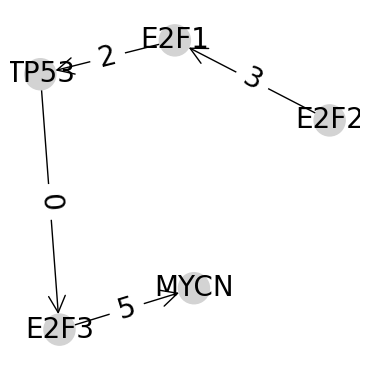

Frequency= 0.0347


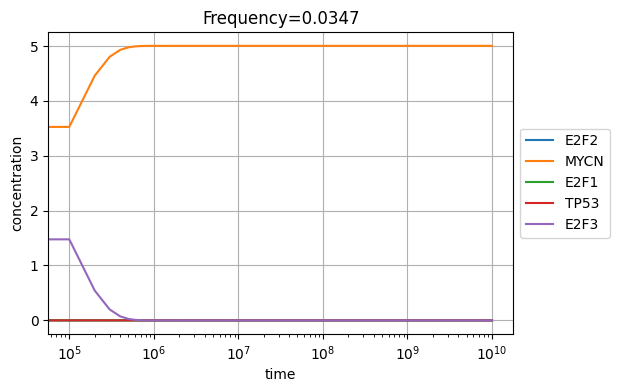

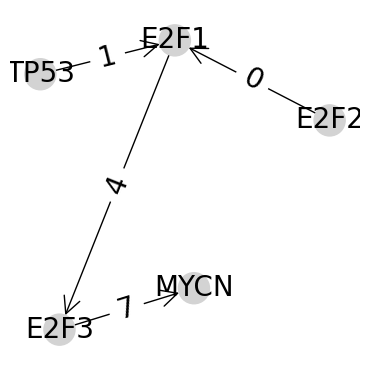

Frequency= 0.0341


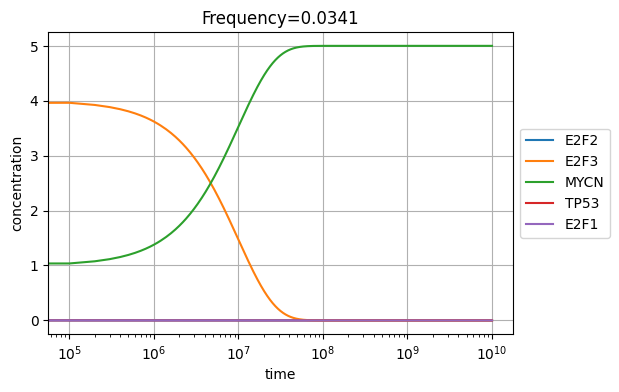

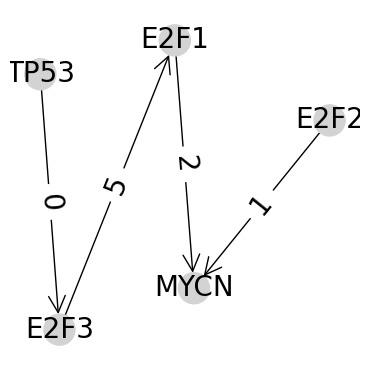

Frequency= 0.0335


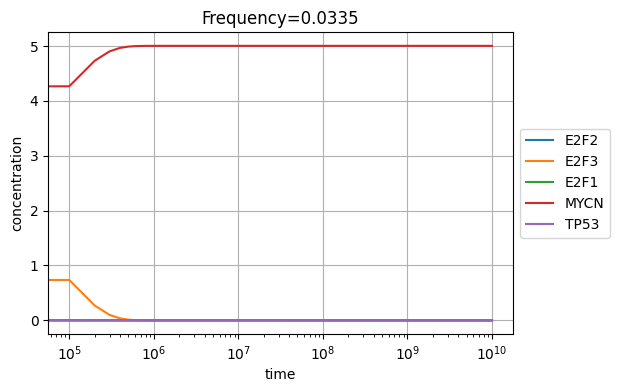

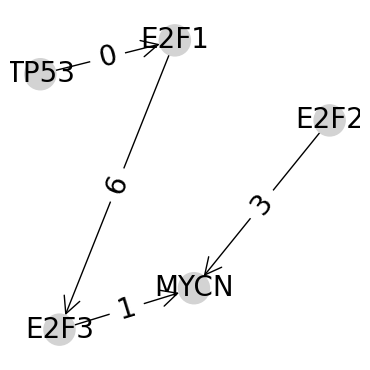

Frequency= 0.0329


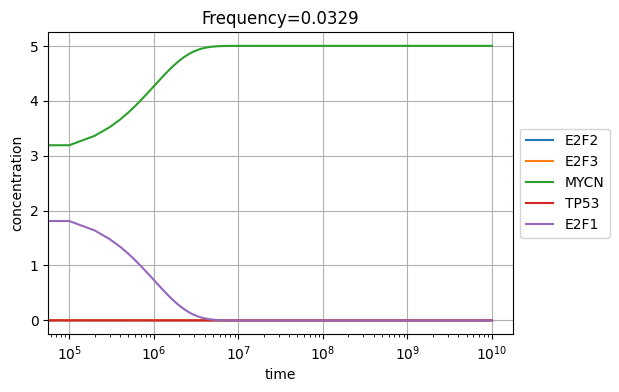

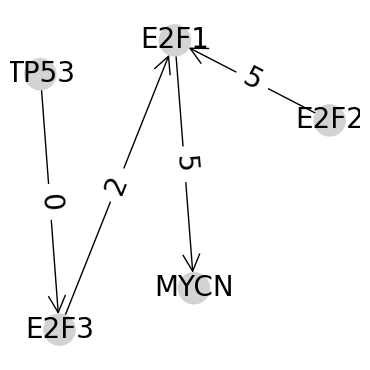

Frequency= 0.0323


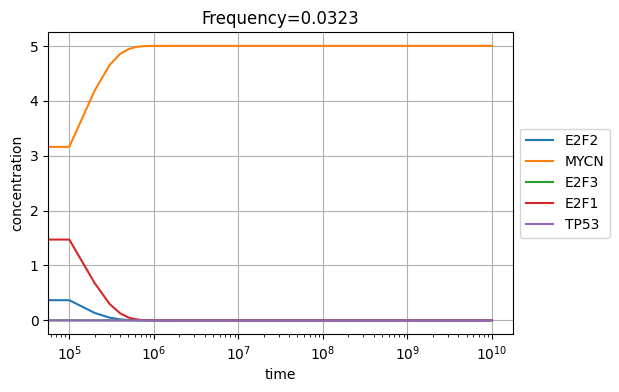

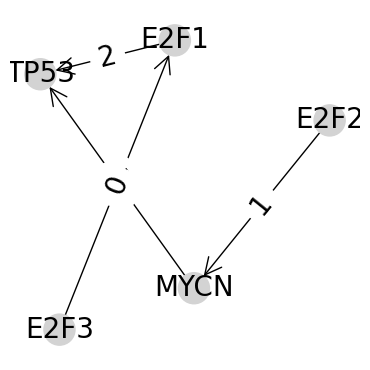

Frequency= 0.0312


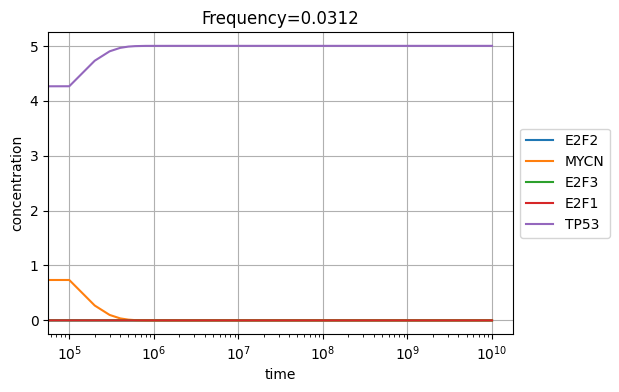

In [346]:
# draw unique graphs
plt.rcParams['figure.dpi']= 100
print('Number of unique graphs = ',len(unique_reduced))


max_number_of_graphs = 5
most_frequent = True
if most_frequent:
    irx = np.argsort(-np.array(counts))
else:
    irx = np.argsort(np.array(counts))
    
do_plot_dynamics = True
    
timescale=10

k = 0
for i in irx:
    ugr = unique_reduced[i]
    plt.figure(figsize=(3.5,3.5))
    color_map = []
    for n in ugr:
        color_map.append('lightgray')
    nx.draw(ugr, pos, with_labels = True,node_color=color_map,font_size=20,node_size=500,arrowsize=30,arrowstyle='->')
    edge_labels = get_edge_labels_dic(ugr)
    nx.draw_networkx_edge_labels(ugr,pos,edge_labels=edge_labels,font_color='black',font_size=20)
    plt.show()
    print('Frequency=',counts[i]/total_counts)
    if do_plot_dynamics:
        plot_dynamics(ugr,title='Frequency='+str(counts[i]/total_counts),timescale=timescale)
    k+=1
    if k>max_number_of_graphs:
        break

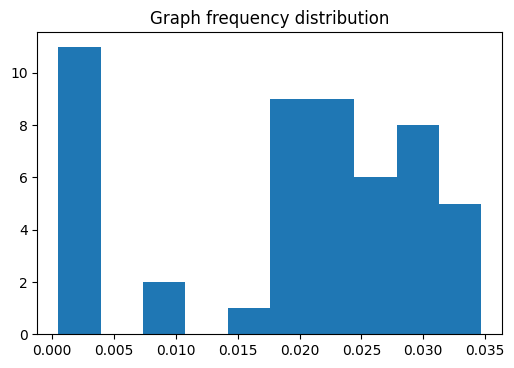

In [312]:
plt.hist(np.array(counts)[irx]/total_counts)
plt.title('Graph frequency distribution')
plt.show()